In [1]:
#1. 필요한 라이브러리 설치
!pip install pysal
!pip install pandas geopandas spreg pysal shapely


# 라이브러리 임포트
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
import matplotlib.patches as mpatches
from google.colab import drive
import warnings
import numpy as np
from spreg import OLS
from libpysal.weights import Queen
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# pysal 라이브러리 임포트
import pysal.lib
import pysal.model
from pysal.model import spreg
from statsmodels.tools import add_constant


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#2. 성남시 데이터 추출

# Google Drive 연결
drive.mount('/content/drive')

# SHAPE 파일 경로 설정
shp_path = "/content/빅데기/성남시_SIG_5179.shp"

# SHAPE 파일을 읽어서 GeoDataFrame으로 만듭니다
gdf = gpd.read_file(shp_path)

# 좌표계 설정 (성남시)
gdf.crs = 'EPSG:5179'

# 성남시 데이터만 추출
seongnam_gu_codes = ['41131', '41133', '41135']
gdf_seongnam = gdf[gdf['SIG_CD'].isin(seongnam_gu_codes)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#3. 공장 데이터 준비

# 공장 데이터 파일 경로 설정
factory_path = "/content/빅데기/공장등록현황.csv"

# 공장 데이터 읽기 (EUC-KR 인코딩)
factories = pd.read_csv(factory_path, encoding='EUC-KR')


# 위도와 경도를 사용하여 Point 객체 생성
factories['geometry'] = factories.apply(lambda row: Point(row['경도'], row['위도']), axis=1)

# 공장 데이터 GeoDataFrame으로 변환
gdf_factories = gpd.GeoDataFrame(factories, geometry='geometry', crs="EPSG:4326")

# 공장 데이터 좌표계 변환 (성남시 좌표계 EPSG:5179에 맞게)
gdf_factories = gdf_factories.to_crs(epsg=5179)

In [4]:
#4.PM10 데이터 준비 및 확인

# 엑셀 파일 경로 설정
excel_file = "/content/빅데기/구별_미세먼지_농도.xlsx"

# 엑셀 파일 읽기
df = pd.read_excel(excel_file)

# 각 구의 PM10 농도 평균 계산
pm10_avg = df.groupby('gu')['PM10'].mean().round(3).reset_index()

# 결과 출력
print(pm10_avg)


# PM10 데이터 준비
pm10_avg = pd.DataFrame({
    'SIG_ENG_NM': ['Sujeong-gu, Seongnam-si', 'Jungwon-gu, Seongnam-si', 'Bundang-gu, Seongnam-si'],
    'PM10': pm10_avg['PM10']
})

# PM10 데이터와 구 이름 매칭 확인
print("Available districts in SHAPE file:", gdf_seongnam['SIG_ENG_NM'].unique())
print("Available districts in PM10 data:", pm10_avg['SIG_ENG_NM'].unique())


           gu    PM10
0  Bundang-gu  38.166
1  Jungwon-gu  36.927
2  Sujeong-gu  37.682
Available districts in SHAPE file: ['Sujeong-gu, Seongnam-si' 'Jungwon-gu, Seongnam-si'
 'Bundang-gu, Seongnam-si']
Available districts in PM10 data: ['Sujeong-gu, Seongnam-si' 'Jungwon-gu, Seongnam-si'
 'Bundang-gu, Seongnam-si']


<ipython-input-5-490a7849c75b>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


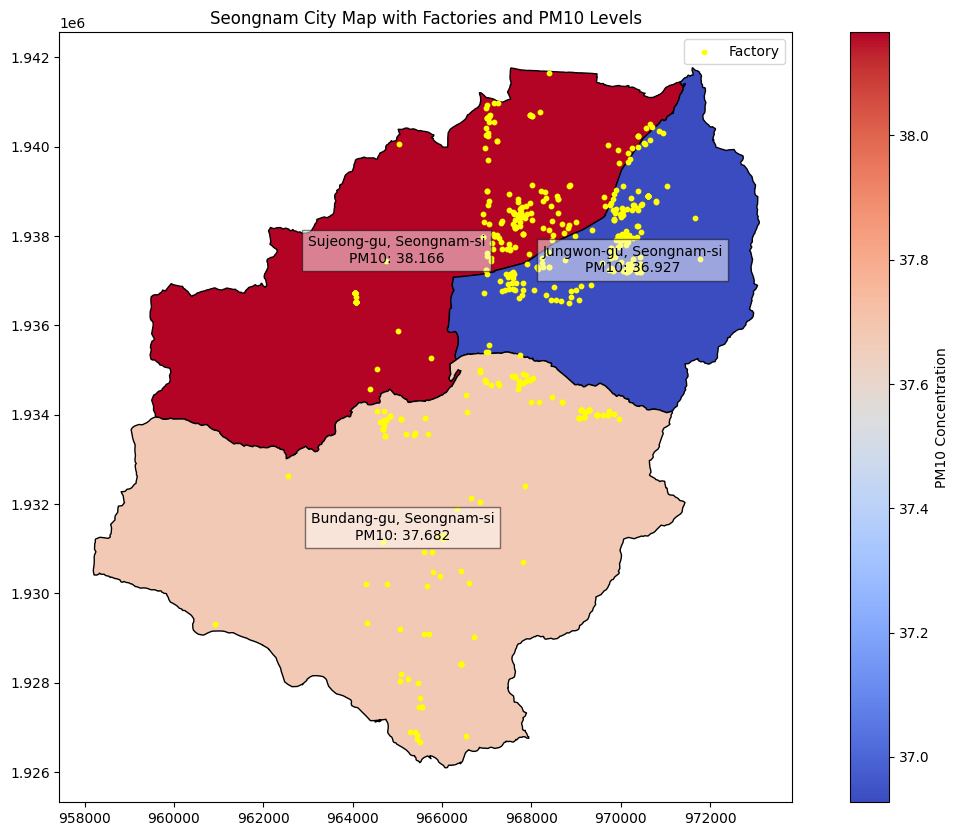

In [5]:
#5. 성남시의 공장 위치 및 미세먼지 농도(평균) 시각화

# 지도 시각화
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# 구별 PM10 농도 색상 설정
norm = mcolors.Normalize(vmin=pm10_avg['PM10'].min(), vmax=pm10_avg['PM10'].max())
cmap = plt.cm.get_cmap('coolwarm')

# 성남시 지도 그리기
for idx, row in gdf_seongnam.iterrows():
    gu_name = row['SIG_ENG_NM']
    pm10_value = pm10_avg.loc[pm10_avg['SIG_ENG_NM'] == gu_name, 'PM10'].values
    if len(pm10_value) > 0:
        color = cmap(norm(pm10_value[0]))
        gdf_seongnam.loc[idx:idx].plot(ax=ax, color=color, edgecolor='black')

# 공장 위치 그리기
gdf_factories.plot(ax=ax, color='yellow', markersize=10, label='Factory')

# 구별 이름과 PM10 농도 텍스트로 표시
for idx, row in gdf_seongnam.iterrows():
    gu_name = row['SIG_ENG_NM']
    pm10_value = pm10_avg.loc[pm10_avg['SIG_ENG_NM'] == gu_name, 'PM10'].values
    if len(pm10_value) > 0:
        plt.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{gu_name}\nPM10: {pm10_value[0]}",
                 horizontalalignment='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# 범례 설정
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PM10 Concentration')

plt.title('Seongnam City Map with Factories and PM10 Levels')
plt.legend()
plt.show()


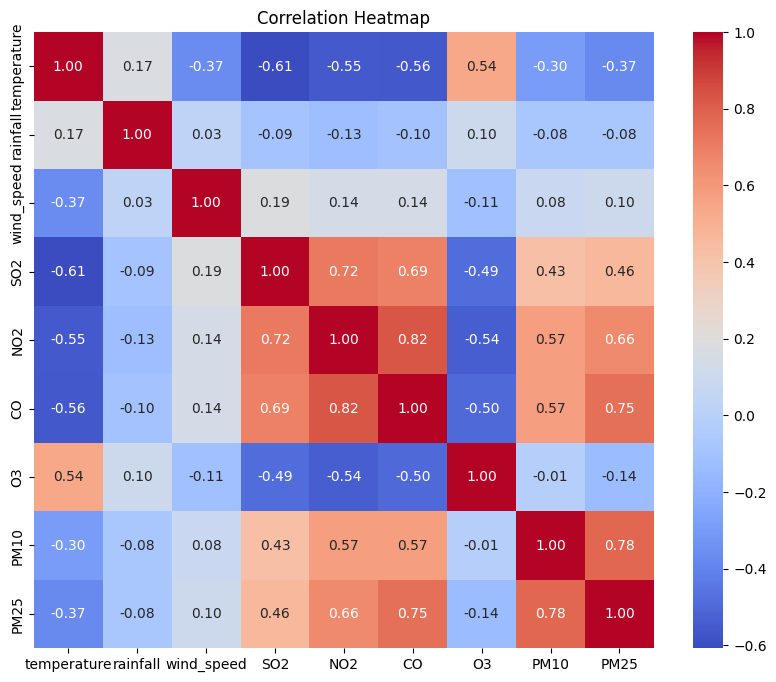

In [6]:
#6. 상관분석 히트맵

# 엑셀 파일 경로 설정
file_path = '/content/빅데기/bigdata.xlsx'
df = pd.read_excel(file_path)

# 일시를 제외한 나머지 변수 선택
data = df.drop(columns=['date'])

# 상관행렬 계산
correlation_matrix = data.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


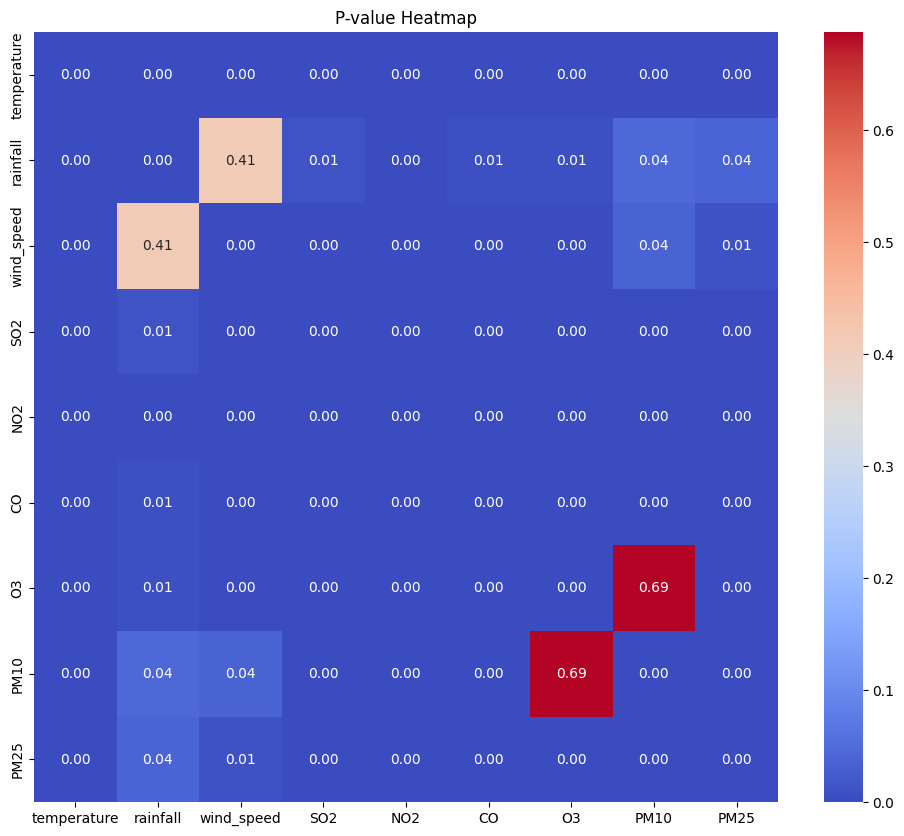

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 엑셀 파일 경로 설정
file_path = '/content/빅데기/bigdata.xlsx'
df = pd.read_excel(file_path)

# 일시를 제외한 나머지 변수 선택
data = df.drop(columns=['date'])

# 상관계수와 p-value를 저장할 데이터프레임 생성
corr_matrix = pd.DataFrame(np.zeros((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns)
pval_matrix = pd.DataFrame(np.zeros((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns)

# 각 변수 쌍에 대해 상관계수와 p-value 계산
for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        if i == j:
            corr_matrix.iloc[i, j] = 1.0
            pval_matrix.iloc[i, j] = 0.0
        else:
            corr, pval = pearsonr(data.iloc[:, i], data.iloc[:, j])
            corr_matrix.iloc[i, j] = corr
            pval_matrix.iloc[i, j] = pval


# 상관분석 p-value 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(pval_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('P-value Heatmap')
plt.show()


In [8]:
#7. 합계 및 평균으로 나온 공간회귀분석결과(부적절)


# 미세먼지 데이터
pm10_data = pd.DataFrame({
    'gu': ['Sujeong-gu', 'Jungwon-gu', 'Bundang-gu'],
    'PM10': [37.681899, 36.927098, 38.166314]
})

# 성남시 데이터
seongnam_data = pd.DataFrame({
    'SIG_CD': ['41131', '41133', '41135'],
    'SIG_ENG_NM': ['Sujeong-gu, Seongnam-si', 'Jungwon-gu, Seongnam-si', 'Bundang-gu, Seongnam-si']
})

# 매핑 확인
pm10_data['SIG_CD'] = pm10_data['gu'].map({
    'Sujeong-gu': '41131',
    'Jungwon-gu': '41133',
    'Bundang-gu': '41135'
})

# 병합하여 확인
merged_pm10_data = pd.merge(pm10_data, seongnam_data, on='SIG_CD', how='left')

# 공장 데이터 (가상 데이터 사용)
factory_counts = pd.DataFrame({
    'SIG_CD': ['41131', '41133', '41135'],
    'factory_count': [162, 166, 254]
})

# 병합
merged_data = pd.merge(merged_pm10_data, factory_counts, on='SIG_CD')

# 공간 회귀 분석 수행을 위한 데이터 설정
y = np.array(merged_data['PM10'])
X = np.array(merged_data[['factory_count']])
X = add_constant(X)

# 예시로 사용할 공간 데이터프레임 생성 (실제 데이터 필요)
# 성남시 각 구의 중앙 위치 위도 경도 : QGIS - 카카오맵 - 웹툴.com - 주소를 위도 경도로 변환
# gdf_seongnam = gpd.read_file('path_to_seongnam_shapefile.shp')
gdf_seongnam = gpd.GeoDataFrame({
    'geometry': [Point(127.10449942592776, 37.43510872988051), Point(127.16395212076849, 37.43345543188643), Point(127.10610206714574, 37.379337774634315)],
    'SIG_CD': ['41131', '41133', '41135']
})

# 공간 가중치 행렬 생성
w = Queen.from_dataframe(gdf_seongnam)
w.transform = 'r'

# 공간 회귀 모델 적합
model = OLS(y, X, w=w, name_y='PM10', name_x=['Intercept', 'factory_count'])
print(model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        PM10                Number of Observations:           3
Mean dependent var  :     37.5918                Number of Variables   :           2
S.D. dependent var  :      0.6245                Degrees of Freedom    :           1
R-squared           :      0.5974
Adjusted R-squared  :      0.1948
Sum squared residual:    0.314042                F-statistic           :      1.4838
Sigma-square        :       0.314                Prob(F-statistic)     :      0.4376
S.E. of regression  :       0.560                Log likelihood        :      -0.872
Sigma-square ML     :       0.105                Akaike info criterion :       5.743
S.E of regression ML:      0.3235                Schwarz criterion     :       3.940

------------------------------------------------------------

<ipython-input-8-2c8b91788ae3>:49: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_seongnam)


In [9]:
#8.PM10 단계선택법을 활용한 다중 회귀분석

import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 엑셀 파일에서 데이터 불러오기
file_path = '/content/빅데기/bigdata.xlsx'  # 파일 경로를 확인하세요.
data = pd.read_excel(file_path)

# 'date' 열 제외하고 필요한 열만 추출
data_cleaned = data.drop(columns=['date'])

# 결측값 처리 (예: 제거 또는 평균값으로 채우기)
data_cleaned = data_cleaned.dropna()

# 독립변수 (X)와 종속변수 (y) 정의
X = data_cleaned.drop(columns=['PM10'])
y = data_cleaned['PM10']

# 특징 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 절편을 위한 상수 항 추가
X_scaled = sm.add_constant(X_scaled)

# 스케일링된 배열을 DataFrame으로 변환하여 단계적 선택에 사용
X_df = pd.DataFrame(X_scaled[:, 1:], columns=X.columns)

def stepwise_selection(X, y, significance_level_in=0.05, significance_level_out=0.05):
    """단계적 선택을 통해 선형 모델을 생성합니다."""
    initial_features = list(X.columns)
    best_features = []

    while True:
        changed = False

        # 전진 단계
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[best_features + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < significance_level_in:
            best_feature = new_pval.idxmin()
            best_features.append(best_feature)
            changed = True

        # 후진 단계
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[best_features]))).fit()
        pvals = model.pvalues.iloc[1:]  # 절편을 제외한 p-value
        worst_pval = pvals.max()
        if worst_pval > significance_level_out:
            worst_feature = pvals.idxmax()
            best_features.remove(worst_feature)
            changed = True

        if not changed:
            break

    return best_features

# 단계적 선택 수행
selected_features = stepwise_selection(X_df, y)

# 선택된 특징으로 최종 모델 피팅
final_X_train = sm.add_constant(X_df[selected_features])
final_model = sm.OLS(y, final_X_train).fit()

# 최종 모델 요약 출력
final_model_summary = final_model.summary()
print(final_model_summary)


                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     269.1
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          4.55e-162
Time:                        13:13:36   Log-Likelihood:                -2806.2
No. Observations:                 726   AIC:                             5624.
Df Residuals:                     720   BIC:                             5652.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.9598      0.430     88.213      0.0

In [10]:
#9.PM25 단계선택법을 활용한 다중 회귀분석


# 엑셀 파일에서 데이터 불러오기
file_path = '/content/빅데기/bigdata.xlsx'  # 파일 경로를 확인하세요.
data = pd.read_excel(file_path)

# 'date' 열 제외하고 필요한 열만 추출
data_cleaned = data.drop(columns=['date'])

# 결측값 처리 (예: 제거 또는 평균값으로 채우기)
data_cleaned = data_cleaned.dropna()

# 독립변수 (X)와 종속변수 (y) 정의
X = data_cleaned.drop(columns=['PM25'])
y = data_cleaned['PM25']

# 특징 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 절편을 위한 상수 항 추가
X_scaled = sm.add_constant(X_scaled)

# 스케일링된 배열을 DataFrame으로 변환하여 단계적 선택에 사용
X_df = pd.DataFrame(X_scaled[:, 1:], columns=data_cleaned.columns[:-1])

def stepwise_selection(X, y, significance_level_in=0.05, significance_level_out=0.05):
    """Perform stepwise selection for the linear model."""
    initial_features = list(X.columns)
    best_features = []

    while True:
        changed = False

        # 전진 단계
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[best_features + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < significance_level_in:
            best_feature = new_pval.idxmin()
            best_features.append(best_feature)
            changed = True

        # 후진 단계
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[best_features]))).fit()
        pvals = model.pvalues.iloc[1:]  # exclude the intercept
        worst_pval = pvals.max()
        if worst_pval > significance_level_out:
            worst_feature = pvals.idxmax()
            best_features.remove(worst_feature)
            changed = True

        if not changed:
            break

    return best_features

# 단계별 선택 수행
selected_features = stepwise_selection(X_df, y)

# 선택된 특징으로 최종 모델 피팅
final_X_train = sm.add_constant(X_df[selected_features])
final_model = sm.OLS(y, final_X_train).fit()

# 최종 모델 요약 출력
final_model_summary = final_model.summary()
print(final_model_summary)


                            OLS Regression Results                            
Dep. Variable:                   PM25   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     449.3
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          1.50e-218
Time:                        13:13:37   Log-Likelihood:                -2385.7
No. Observations:                 726   AIC:                             4783.
Df Residuals:                     720   BIC:                             4811.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.7353      0.241     81.848      0.0

Epoch 1/200
9/9 [==============================] - 14s 247ms/step - loss: 0.0471
Epoch 2/200
9/9 [==============================] - 2s 174ms/step - loss: 0.0272
Epoch 3/200
9/9 [==============================] - 1s 147ms/step - loss: 0.0250
Epoch 4/200
9/9 [==============================] - 1s 142ms/step - loss: 0.0245
Epoch 5/200
9/9 [==============================] - 2s 171ms/step - loss: 0.0230
Epoch 6/200
9/9 [==============================] - 1s 127ms/step - loss: 0.0223
Epoch 7/200
9/9 [==============================] - 1s 159ms/step - loss: 0.0230
Epoch 8/200
9/9 [==============================] - 2s 177ms/step - loss: 0.0224
Epoch 9/200
9/9 [==============================] - 1s 92ms/step - loss: 0.0231
Epoch 10/200
9/9 [==============================] - 1s 137ms/step - loss: 0.0225
Epoch 11/200
9/9 [==============================] - 1s 148ms/step - loss: 0.0227
Epoch 12/200
9/9 [==============================] - 1s 156ms/step - loss: 0.0227
Epoch 13/200
9/9 [===================

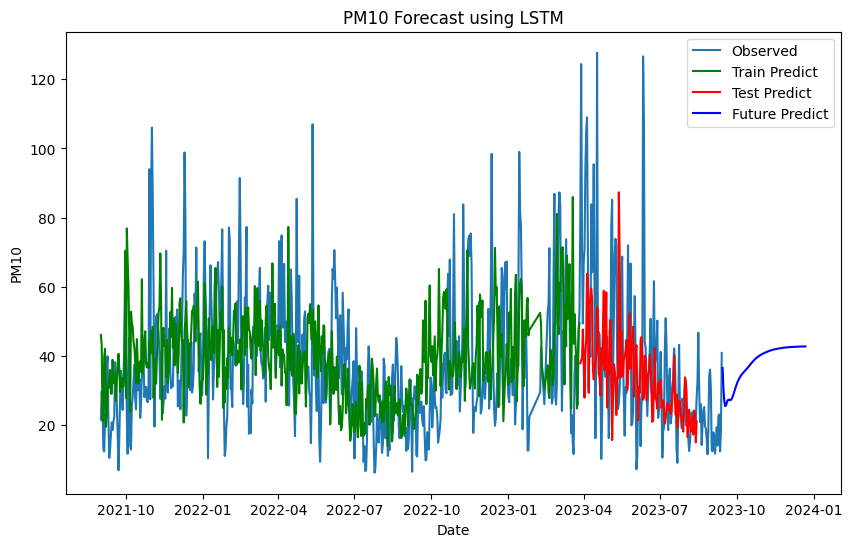

Train MSE: 226.42075320283493, Train RMSE: 15.04728391447556, Train MAE: 11.027165602364827
Test MSE: 205.25178546375344, Test RMSE: 14.326611094873535, Test MAE: 9.779030465106576


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# 데이터 로드 및 전처리
df = pd.read_excel('/content/빅데기/bigdata.xlsx')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df['PM10'] = df['PM10'].interpolate()

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['PM10']])

# 시계열 데이터셋 생성
def create_dataset(data, look_back=30):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X, Y = create_dataset(df_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# 데이터 분할 (80% 훈련, 20% 테스트)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, Y_train, batch_size=64, epochs=200)  # 에포크 수 증가

# 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 원래 스케일로 되돌리기
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# 더 먼 미래 예측 (2023년 12월까지)
future_steps = 100  # 예측할 미래의 데이터 포인트 수 (예: 100일)

# 마지막 테스트 데이터 포인트를 시작점으로 예측
last_window = df_scaled[-look_back:]
future_predictions = []

for _ in range(future_steps):
    future_pred = model.predict(last_window.reshape(1, look_back, 1))
    future_predictions.append(future_pred[0, 0])
    last_window = np.append(last_window[1:], future_pred[0, 0]).reshape(look_back, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['PM10'], label='Observed')
plt.plot(df.index[:len(train_predict)], train_predict.flatten(), label='Train Predict', color='green')
plt.plot(df.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict.flatten(), label='Test Predict', color='red')

# 미래 예측 날짜 생성
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, inclusive='right')

plt.plot(future_dates, future_predictions.flatten(), label='Future Predict', color='blue')
plt.title('PM10 Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.legend()
plt.show()

# 평가지표 계산
train_mse = mean_squared_error(Y_train[0], train_predict.flatten())
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(Y_train[0], train_predict.flatten())

test_mse = mean_squared_error(Y_test[0], test_predict.flatten())
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(Y_test[0], test_predict.flatten())

print(f'Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train MAE: {train_mae}')
print(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAE: {test_mae}')
